# Objective

The objective of this project is to build an image classifier to recognize different species of flowers.
The application will prepared as command line to train this classifier , then export it to get is consumed in another application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories. 

The process followed in explaining the code is :

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content


At the end of this you'll have an application that can be trained on any set of labeled images. Here the network will be learning about flowers and end up as a command line application. 

Note :Use GPU to speed the learning process of the model.


The development begins from here : 
-----------------------------------------


In [0]:
%matplotlib inline 
%config InlineBackend.figure_format="retina"
# Imports here
import torch
from torch import nn , optim
import torch.nn.functional as F
from torchvision import datasets, transforms , models
import time
from torch.optim import lr_scheduler
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import json

## Load the data

Points:  
> Here `torchvision` inbuilt dataloader function is used to load the image datsets

> The dataset is split into three parts, training, validation, and testing.

> Training dataset is apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance
> The input data is resized to 224x224 pixels as required by the pre-trained networks

> Data has also been normalized. This is required since to pre-trained convolutional networks need to be used to build the models. This technique of transfer laerning ( i.e using pre-trained models) will drastically reduce the effort and time to make the model learn. 

 

In [0]:
#Creating dictionary for train, valid & test sets
#make sure the primary directory is linked to the data_dir variable
data_dir = 'flowers_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

maps=dict([('train',train_dir), ('valid', valid_dir), ('test', test_dir)])

In [0]:
# Defining your transforms for the training, validation, and testing sets

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(45),
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
     ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
     ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
     ])
}



# Creating the function to Load the datasets with ImageFolders withe the required transformations indicated above.

def loader(var,collect=maps) :
    image_datasets = datasets.ImageFolder(collect[var],transform=data_transforms[var])
    dataloaders = torch.utils.data.DataLoader(image_datasets,batch_size=64)
    return dataloaders, image_datasets

In [0]:
#Avoid this approach, memory runs out during compilation. 
#Collecting all tensors value into one variable. 

def load_set(var):
    testloader=loader(var)
    test_set=[]
    test_label=[]
    for image,label in testloader:
        test_set.append(image)
        test_label.append(label)
    test_set = torch.cat(test_set, dim=0)
    test_label=torch.cat(test_label, dim=0)
    return test_set, test_label

#dataset = dict ([("train", load_set("train")),("valid", load_set("valid")),("test", load_set("test"))])

In [0]:
#creating a dictionary for data files and loader functions for utilizing it in the model 
trainloader, train_set=loader('train')
validloader, valid_set=loader("valid")
testloader, test_set=loader('test')

loadset=dict([("train",trainloader),("valid", validloader), ("test", testloader)])
set_dict=dict([("train",train_set),("valid", valid_set),("test", test_set)])

# Building and training the classifier

Following steps are used to create the pretrained models. 
* One of the pretrained models from [`torchvision.models`](http://pytorch.org/docs/master/torchvision/models.html) is loaded into the model.
* End classification layer (dense network) is wrapped over to the pre-trained convultional network. 
* Resultant complete model is then trained to get the features from pre-trained network and classifier network. 
* The hyperparameters are changed to enhance the loss & accuracy of the model.


In [0]:
# Checked the feasibility with different pre-trained models
#models=models.densenet121(pretrained=True)
#models=models.vgg11(pretrained=True)

In [0]:
#Below function helps to generate a model from scratch for training .
def model_generate (model_type='alexnet') :
    if model_type=="alexnet":
        model=models.alexnet(pretrained=True)
        model_inputs=9216
        hidden_no=256
    elif model_type =="vgg19":
        model=models.vgg19(pretrained=True)
        model_inputs=25088
        hidden_no=4096
    else :
        raise ValueError ('model architecture is not supported') 
    
    for params in model.parameters():
        params.required_grad=False
    
    hidden_no=4096
    num_classes=102
    dr=0.5#dropout ratio
    
    classifier=nn.Sequential( OrderedDict([('fc1',nn.Linear(model_inputs,hidden_no)),
                              ('rel1',nn.ReLU()),
                              #('D1',nn.Dropout(dr)),
                              #('fc2',nn.Linear(hidden_no,hidden_no)),
                              #('rel2',nn.ReLU()),
                              #('D2',nn.Dropout(dr)),
                              ('fc3',nn.Linear(hidden_no,num_classes))])) #,('output',nn.LogSoftmax(dim=1))
    
    model.classifier = classifier 
    
    #optimizer = optim.Adam(model.classifier.parameters(), lr=0.01)
    
    #criteria = nn.NLLLoss()
    optimizer = optim.SGD(model.classifier.parameters(), lr=0.001, momentum=0.9)
    criteria = nn.CrossEntropyLoss()
    sched=lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)
    return model, optimizer , criteria, sched

In [0]:
# this function not required. Created to reduce the no. of iterations, but requires too much memory to compute.
def score_mo(model,mode, option , criteria) :
    model.to(mode)
    model.eval()
    accuracy = 0
    loss=0
    data = dataset[option]
    image=data[0]
    labels=data[1]
    image =image.to(mode)
    labels=labels.to(mode)
    outputs=model.forward(image)
    ps=torch.exp(outputs)
    top_ps, top_label=ps.topk(1,dim=1)
    equal= top_label==labels.view(*top_label.shape)
    accuracy+=torch.mean(equal.type(torch.FloatTensor))
    loss+=criteria(outputs,labels).item()
    return accuracy, loss
         

In [0]:
# Function to calculate the model's running accuracy & loss_value
def score_model(model,mode, phase, criteria ) :
    model.to(mode)
    model.eval()
    accuracy = 0
    loss=0
    for image, labels in loadset[phase]:
        image =image.to(mode)
        labels=labels.to(mode)
        with torch.set_grad_enabled(False):
            outputs=model.forward(image)
            #ps=torch.exp(outputs)
            loss+=criteria(outputs,labels).item()
            exp, preds = torch.max(outputs, 1)
        corrects=torch.sum(preds==labels.data)
        #top_ps, top_label=ps.topk(1,dim=1)
        #equal= top_label==labels.view(*top_label.shape)
        accuracy+=corrects #torch.mean(equal.type(torch.FloatTensor))
        
    return accuracy.double()/len(set_dict[phase]) , loss

In [0]:
#Function to train the model. 

def train_model (model,mode,epochs, phase, optimizer, criterion ,scheduler):
    if mode=="cuda":
        device=torch.device("cuda:0")
        model.cuda()
    #model.to(mode)
    steps=0
    for e in range(epochs) :
        model.train()
        start = time.time()
        for image , labels in loadset[phase]:
            image =image.to(mode)
            labels=labels.to(mode)
            optimizer.zero_grad()
            outputs=model.forward(image)
            loss=criterion(outputs,labels)
            loss.backward()
            optimizer.step()
            steps+=1
            #if steps % 300 == 0 :
            #    print(steps, "Steps done")
        if e %5 == 0 : 
            accuracy, running_loss = score_model(model,mode,phase, criterion)
            print("Accuracy is {a} at epoch = {b} & steps = {d} ; loss = {c}".format(a=accuracy,b=e, c=running_loss, d=steps))
            model.train()
            print((time.time()-start), "seconds per epoch")
        scheduler.step()
    print("Training Done")   
    return model

In [0]:
#function to load the model from the previouly saved checkpoint
def load_model(filepath) :
    checkpoint = torch.load(filepath, map_location='cpu')
    var = checkpoint['model']
    model, optimizer,criterion,scheduler =model_generate(var)
    model.load_state_dict(checkpoint['state_dict'], strict=False)
    model.class_to_idx = checkpoint['class_to_idx']
    optimizer.load_state_dict(checkpoint['optimizer'])
    return model, optimizer, criterion, scheduler

In [0]:
#Below function is to save the model on to hard-disk for later use . 
def model_save (model,arch_type,optimizer,train_data, filepath = 'ckpoint.pth') :
    model.class_to_idx= train_data.class_to_idx
    checkpoint_dict= {
              'model': arch_type,
              'optimizer': optimizer.state_dict(),
              'state_dict': model.state_dict(),
              'class_to_idx': model.class_to_idx
             }
    torch.save(checkpoint_dict, filepath)
    print ("Model saved with filepath '{}' ".format (filepath))

In [0]:
#Following steps are to run the model and train it 
hparams= {
    "epoch":25,
    "l_rate":0.001,
    "momentum":0.9,
    "model-1":"alexnet",
    "model-2":"vgg19",
    "st_size": 4,
    "gamma":0.1,
}

other_params={
    "filepath":"ckpoint_alex.pth"
}

model_new, optimizer , criteria, sched = model_generate(hparams["model-1"])
#print(model_new)
new_optimizer = optim.SGD(model_new.classifier.parameters(), lr=hparams["l_rate"], momentum=hparams["momentum"])
scheduler=lr_scheduler.StepLR(new_optimizer, step_size=hparams["st_size"], gamma=hparams["gamma"])
new_model=train_model(model_new,"cuda", hparams["epoch"] , "train", new_optimizer, criteria, scheduler)
model_save (new_model,hparams["model-1"] ,new_optimizer,train_set, filepath = other_params["filepath"])


Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth
100%|██████████| 233M/233M [00:03<00:00, 77.1MB/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Accuracy is 0.054181929181929184 at epoch = 0 ; loss = 454.7279779911041
2069.12979054451 seconds per epoch
300 Steps done
600 Steps done
Accuracy is 0.26587301587301587 at epoch = 5 ; loss = 335.0530786514282
166.64897632598877 seconds per epoch
900 Steps done
Accuracy is 0.3311965811965812 at epoch = 10 ; loss = 309.31083154678345
167.2555148601532 seconds per epoch
1200 Steps done
1500 Steps done
Accuracy is 0.3344017094017094 at epoch = 15 ; loss = 308.833857357502
164.8567066192627 seconds per epoch
1800 Steps done
2100 Steps done
Accuracy is 0.33485958485958484 at epoch = 20 ; loss = 309.1649435162544
167.61023831367493 seconds per epoch
2400 Steps done
Training Done
Model saved with filepath 'ckpoint_alex.pth' 


In [17]:
model_new, new_optimizer, criteria, scheduler = load_model('ckpoint_alex.pth')

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth
100%|██████████| 233M/233M [00:11<00:00, 21.9MB/s]


In [18]:
test_accuracy, test_loss = score_model (model_new,"cuda","valid" , criteria)
print("Accuracy on validation set is ", float(test_accuracy.float())*100, "%")

Accuracy on validation set is  39.608803391456604 %


#Further training of the model

In [57]:
# let's further train to increase the accuracty
# Can directly load_model for re_training instead of generating the model the again .
#Below command helps to load the model for retraining.
model_new, new_optimizer, criteria, scheduler = load_model('ckpoint_alex.pth')

#below statements to train & save the model
hparams= {
    "epoch":50,
    "l_rate":0.001,
    "momentum":0.9,
    "model-1":"alexnet",
    "model-2":"vgg19",
    "st_size": 4,
    "gamma":0.1,
}

other_params={
    "filepath":"ckpoint_alex.pth"
}

#function to get optimizer parameters to gpu from cpu since optimizer.cuda() doesn't exit
for state in new_optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda()



new_model=train_model(model_new,"cuda", hparams["epoch"] , "train", new_optimizer, criteria, scheduler)
model_save (new_model,hparams["model-1"] ,new_optimizer,train_set, filepath = other_params["filepath"])

Accuracy is 0.48824786324786323 at epoch = 0 & steps = 103 ; loss = 223.45615136623383
159.6125931739807 seconds per epoch
Accuracy is 0.525030525030525 at epoch = 5 & steps = 618 ; loss = 207.90435540676117
153.181391954422 seconds per epoch
Accuracy is 0.58501221001221 at epoch = 10 & steps = 1133 ; loss = 177.24283236265182
152.6064383983612 seconds per epoch
Accuracy is 0.5879120879120879 at epoch = 15 & steps = 1648 ; loss = 177.57474249601364
150.9701111316681 seconds per epoch
Accuracy is 0.5947802197802198 at epoch = 20 & steps = 2163 ; loss = 174.57890325784683
153.6004273891449 seconds per epoch
Training Done
Model saved with filepath 'ckpoint_alex.pth' 


In [71]:
#Let's check the accuracy of our model from further training
test_accuracy, test_loss = score_model (model_new,"cuda","train" , criteria)
print("Accuracy on train set is ", float(test_accuracy.float())*100, "%")
test_accuracy, test_loss = score_model (model_new,"cuda","valid" , criteria)
print("Accuracy on validation set is ", float(test_accuracy.float())*100, "%")

Accuracy on train set is  59.23382043838501 %
Accuracy on validation set is  67.60390996932983 %


## Testing the network

To really evaluate the model, need to run the test images through the network and measure the accuracy. 

In [27]:
# Checking accuracy on the test data set
test_accuracy , test_loss= score_model (model_new,"cuda","test", criteria)
print("Accuracy on test set is ", float(test_accuracy.float())*100, "%")

Accuracy on test set is  55.799758434295654 %


# Inference for classification
To build a function to predict the category of an image. An image is passed into the netowek and prints the class of the image along with the probabilities of top 5 categories

 It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First need to handle processing the input image such that it can be used in the network. 


In [0]:
#Below function converts a given image to nparray 

def process_image(image_loc):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    image_transformation = transforms.Compose([transforms.Resize(256),
                                              transforms.CenterCrop(224),
                                              transforms.ToTensor() ])
    
    image_open=Image.open(image_loc)
    image_file=image_transformation(image_open).float()
    
    image_nparray=np.array(image_file)
    
    mean=np.array([0.485,0.456, 0.406])
    std=np.array([0.229, 0.224, 0.225])
    final_image=(np.transpose(image_nparray,(1,2,0))-mean)/std
    final_image=np.transpose(final_image,(2,0,1))
    
    return final_image


To check the work, the function below converts a PyTorch tensor and displays as image it in the notebook.

In [0]:
#Helper function to plot the image   @ credits to Udacity Team

def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
        
    if title : 
        plt.title(title)
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std*image+mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

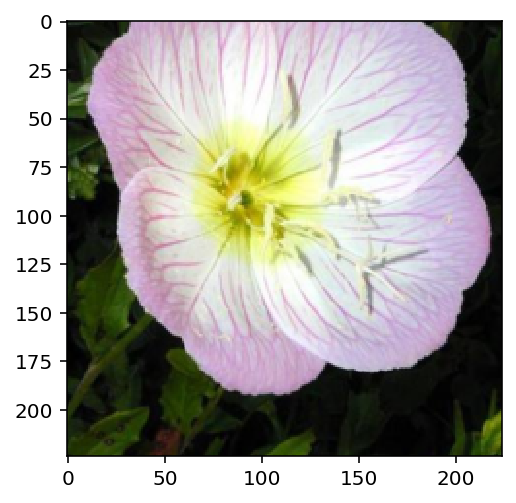

In [30]:
#checking the image_processing function : 
path = 'flowers_data/test/1/image_06743.jpg'
img = process_image(path)
imshow(img)

## Class Prediction

Following function for making predictions with your model



In [0]:
#Need to load in a mapping from category label to category name. 
#below json file contains dictionary which maps the integer encoded categories to the actual names of the flowers.
c=open("cat_to_name.json","r")
cat_to_name=json.load(c)
# The code to predict the class from an image file :
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    img=process_image(image_path)
    img=torch.from_numpy(img).type(torch.FloatTensor)
    img=torch.unsqueeze(img,0) # reference = https://discuss.pytorch.org/t/expected-stride-to-be-a-single-integer-value-or-a-list/17612
    
  
    img =img.to("cuda")
    output=model.forward(img)
    output=output.cpu()
    probs_log=nn.functional.log_softmax(output.data, dim=1)
    probs=torch.exp(probs_log)
    top_probs, top_labelle = probs.topk(topk) 
    top_probs=top_probs.numpy()[0]
    top_labelle= top_labelle.data.numpy()[0]
    
    id_to_class = {item : key for key, item in model.class_to_idx.items()}
    top_labels=[id_to_class[x] for x in top_labelle]
    flowerName=[cat_to_name[id_to_class[x]] for x in top_labelle]
    
    return top_probs, top_labels, flowerName
    
   

## Final Check by plotting the image and output from prediction



In [0]:
# Display an image along with the top 5 classes

def plot_solution(image_path, model):
    # Set up plot
    plt.figure(figsize = (5,5))
    ax = plt.subplot(2,1,1)
    
    # creating the prediction
    probs, labs, flowers = predict(image_path, model)
    
    # Plot 
    img = process_image(image_path)
    imshow(img, ax , title =flowers[0]);
     
    # bar chart
    plt.subplot(2,1,2)
    sns.barplot(x=probs, y=flowers, color=sns.color_palette()[0]);
    plt.show()   

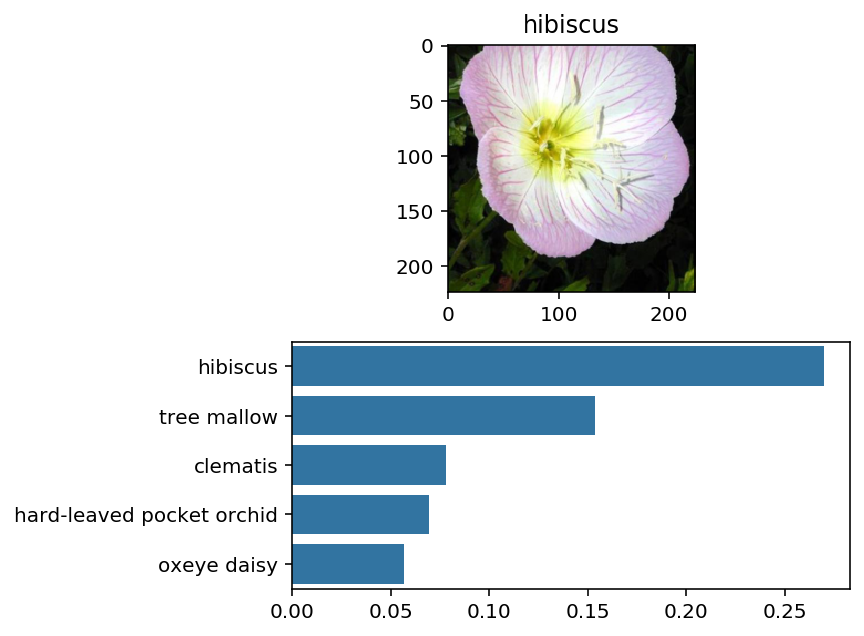

In [56]:
plot_solution('flowers_data/test/1/image_06743.jpg', model_new)

# Creating Python module for image classification

The above indicated code is wrapped into two python file called train.py and predict.py 

1. The prediction is handled by the predict.py file with passing the related argumets 
2. The train.py file help to generate the model or further train the model with a dataset

In [59]:
#check out the arguments to use the predict file 
!python predict.py -h

usage: predict.py [-h] [--gpu] [--k_top K_TOP] [--checkpoint CHECKPOINT]
                  [--category_names [CATEGORY_NAMES]]
                  image_location

positional arguments:
  image_location        provide location of the image. eg=>
                        flowers/train/1/image_06734.jpg

optional arguments:
  -h, --help            show this help message and exit
  --gpu                 indicate the gpu availability
  --k_top K_TOP         K variable indicates no. of predicted top
                        probabilities
  --checkpoint CHECKPOINT
                        to use saved file location of the model
  --category_names [CATEGORY_NAMES]
                        json file with index of categories


In [70]:
# example to use the predict file  
!python predict.py flowers_data/test/1/image_06743.jpg --gpu --checkpoint ckpoint_alex.pth --category_names cat_to_name.json

Names of flower is hibiscus


In [75]:
# Arguments for train.py 
!python train.py -h

usage: train.py [-h] [--arch ARCH] [--gpu] [--save_file SAVE_FILE]
                [--learning_rate LEARNING_RATE] [--hidden_units HIDDEN_UNITS]
                [--epoch EPOCH]
                data_dir

positional arguments:
  data_dir              provide the exact path to the location of data_set eg
                        : 'flowers/train'

optional arguments:
  -h, --help            show this help message and exit
  --arch ARCH           choose architecture from VGG19 or alexnet
  --gpu                 indicate the gpu availability
  --save_file SAVE_FILE
                        give the location to save the trained_model. Default
                        location is 'checkpoint.pth'
  --learning_rate LEARNING_RATE
                        to change the learning rate from 0.001
  --hidden_units HIDDEN_UNITS
                        to change the no. of hidden units from 4096
  --epoch EPOCH         to change the no .of learning rotations from 20


In [77]:
#sample run of train.py 
!python train.py "flowers_data/train" --arch "vgg19" --gpu

previous saved file not found
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
Accuracy is 0.07982295482295482 at epoch = 0 ; loss = 463.23501443862915
396.4831340312958 seconds per epoch
Traceback (most recent call last):
  File "train.py", line 233, in <module>
    new_model=train_model(model_new,device, epochs , "train", new_optimizer, new_criteria, scheduler) 
  File "train.py", line 143, in train_model
    image =image.to(mode)
KeyboardInterrupt
